In [1]:
from matplotlib import pyplot as plt

import pandas as pd

%load_ext autoreload
%autoreload 2

from pytorch_lightning import Trainer
import torch
from pathlib import Path


import pickle

from gnn_tracking.postprocessing.dbscanscanner import DBSCANHyperParamScannerFixed
from gnn_tracking.training.tc import TCModule
from pytorch_lightning.utilities.model_summary import ModelSummary
from ocpaper231.plotutils import Plot

import scienceplots

plt.style.use(["science", "notebook"])
from ocpaper231.data import model_exchange_path
from ocpaper231.names import variable_manager as vm

In [2]:
from ocpaper231.data import get_dm

dm = get_dm(n_val=20)

[14:14:10] INFO: DataLoader will load 900 graphs (out of 900 available).
[14:14:10] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21999_s0.pt


[14:14:10] INFO: DataLoader will load 20 graphs (out of 1000 available).
[14:14:10] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29019_s0.pt


: 

: 

In [3]:
chkpt_path = "/home/kl5675/Documents/23/git_sync/hyperparameter_optimization2/scripts/pixel/lightning_logs/vagabond-tasteful-hyrax/checkpoints_persist/epoch=451-step=406800.ckpt"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
lmodel = TCModule.load_from_checkpoint(chkpt_path, map_location=device)

[19:10:36] DEBUG: Getting class PreTrainedECGraphTCN from module gnn_tracking.models.track_condensation_networks
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'hc_in' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['hc_in'])`.
  rank_zero_warn(
[19:10:36] DEBUG: Getting class MLGraphConstruction from module gnn_tracking.models.graph_construction
[19:10:36] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[19:10:36] DEBUG: Getting class PotentialLoss from module gnn_tracking.metrics.losses
[19:10:36] DEBUG: Getting class DBSCANHyperParamScanner from module gnn_tracking.postprocessing.dbscanscanner


In [30]:
ModelSummary(lmodel)

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | PreTrainedECGraphTCN | 1.9 M 
1 | preproc        | MLGraphConstruction  | 333 K 
2 | potential_loss | PotentialLoss        | 0     
--------------------------------------------------------
1.9 M     Trainable params
333 K     Non-trainable params
2.2 M     Total params
8.950     Total estimated model params size (MB)

# VS EPS

In [10]:
import numpy as np

eps = np.linspace(0.01, 1, 20)
ks = np.arange(1, 5)
trials = []
for e in eps:
    for k in ks:
        trials.append({"eps": e, "min_samples": k})

lmodel.cluster_scanner = DBSCANHyperParamScannerFixed(
    trials=trials,
)

In [11]:
ModelSummary(lmodel)

  | Name           | Type                 | Params
--------------------------------------------------------
0 | model          | PreTrainedECGraphTCN | 1.9 M 
1 | preproc        | MLGraphConstruction  | 333 K 
2 | potential_loss | PotentialLoss        | 0     
--------------------------------------------------------
1.9 M     Trainable params
333 K     Non-trainable params
2.2 M     Total params
8.950     Total estimated model params size (MB)

In [12]:
trainer = Trainer(accelerator=device)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[18:08:27] INFO: DataLoader will load 20 graphs (out of 1000 available).
[18:08:27] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29019_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gp

Validation: 0it [00:00, ?it/s]

NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


In [16]:
class TracksVsDBSCANPlot(Plot):
    def __init__(self, mean_df: pd.DataFrame, **kwargs):
        super().__init__(**kwargs)
        self.df = mean_df.sort_values("eps")
        self.ax.set_xlabel(r"DBSCAN $\varepsilon$")
        self.ax.set_ylabel("Metric")

    def plot_var(self, var, secondary_k=4, **kwargs):
        line, *_ = self.ax.errorbar(
            "eps",
            var,
            yerr=f"{var}_std",
            data=self.df[self.df["min_samples"] == 1],
            label=f"{var}",
            marker="o",
            **kwargs,
        )
        color = line.get_color()
        if secondary_k:
            self.ax.plot(
                "eps",
                var,
                data=self.df[self.df["min_samples"] == secondary_k],
                marker="",
                color=color,
                ls=":",
                label="_hide",
                **kwargs,
            )

In [25]:
with Path("~/paperresults/vs_eps.pkl").expanduser().open("wb") as f:
    pickle.dump(lmodel.cluster_scanner, f)

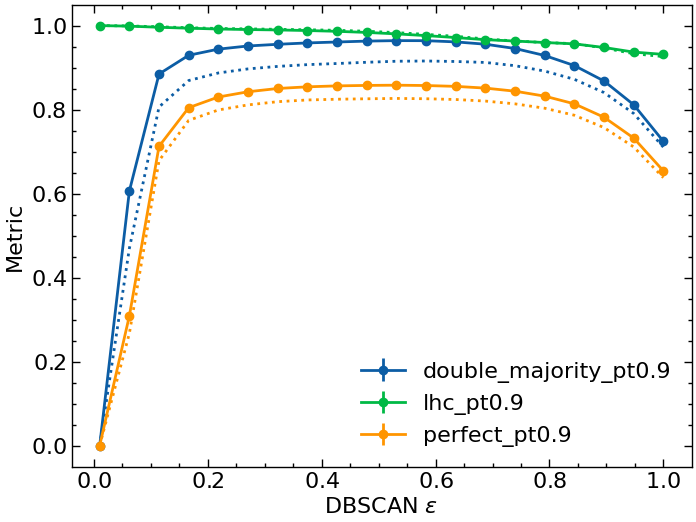

In [22]:
tvdp = TracksVsDBSCANPlot(
    mean_df=lmodel.cluster_scanner.get_results().df_mean,
    # model=model,
    # watermark="outdated",
)
tvdp.plot_var("double_majority_pt0.9")
tvdp.plot_var("lhc_pt0.9")
tvdp.plot_var("perfect_pt0.9")
tvdp.ax.legend()

In [29]:
tvdp.df["double_majority_pt0.9"].max()

0.9642037721968443

In [30]:
max_dm_idx = tvdp.df["double_majority_pt0.9"].argmax()

In [31]:
max_dm_eps = tvdp.df.loc[max_dm_idx]["eps"]
max_dm_eps

0.5310526315789474

In [35]:
tvdp.df.loc[max_dm_idx][["fake_double_majority_pt0.9", "perfect_pt0.9", "lhc_pt0.9"]]

fake_double_majority_pt0.9    0.009222
perfect_pt0.9                 0.858110
lhc_pt0.9                     0.980250
Name: 40, dtype: float64

# vs pt and eta

In [26]:
h_dfs = []
c_dfs = []

In [36]:
from gnn_tracking.postprocessing.dbscanscanner import DBSCANPerformanceDetails

lmodel.cluster_scanner = DBSCANPerformanceDetails(eps=max_dm_eps, min_samples=1)

In [37]:
trainer = Trainer(accelerator="gpu")

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
_ = trainer.validate(lmodel, dm, ckpt_path="last", verbose=False)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:189: UserWarning: .validate(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
[18:23:10] INFO: DataLoader will load 20 graphs (out of 1000 available).
[18:23:10] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29019_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/gp

Validation: 0it [00:00, ?it/s]

In [39]:
import itertools

In [51]:
with Path("~/paperresults/details.pkl").expanduser().open("wb") as f:
    pickle.dump(lmodel.cluster_scanner, f)

In [9]:
with Path("~/paperresults/details.pkl").expanduser().open("rb") as f:
    detail_scanner = pickle.load(f)

In [10]:
h_dfs, c_dfs = detail_scanner.get_results()

In [11]:
from gnn_tracking.metrics.cluster_metrics import (
    tracking_metrics_vs_pt,
    tracking_metrics_vs_eta,
)
import numpy as np


pts = np.array(np.arange(0, 3, 0.3).tolist() + [5.0])
vs_pt = tracking_metrics_vs_pt(h_dfs, c_dfs, pts=pts)
etas = np.array(np.linspace(-4, 4, 20).tolist() + [4.0])
vs_eta = tracking_metrics_vs_eta(h_dfs, c_dfs, etas=etas)
print(len(pts), len(vs_pt), len(etas), len(vs_eta))

11 10 21 20


In [12]:
class PerformancePlot(Plot):
    def __init__(self, xs, df, *, df_ul=None, var="pt", y_label="Efficiency", **kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.df_ul = df_ul
        self.xs = xs
        self.ax.set_xlabel(vm[var])
        self.ax.set_ylabel(y_label)
        self._legend_items = []

    def plot_var(
        self,
        var,
        color,
        *,
        label=None,
        plot_ul=True,
    ):
        stairs = self.ax.stairs(var, edges=self.xs, data=self.df, color=color, lw=1.5)
        if self.df_ul is not None and plot_ul:
            self.ax.stairs(
                var, edges=self.xs, data=self.df_ul, color=color, lw=1.5, ls=":"
            )
        mids = (self.xs[:-1] + self.xs[1:]) / 2
        if label is None:
            label = vm[var].latex
        bar = self.ax.errorbar(
            mids,
            var,
            yerr=f"{var}_err",
            ls="none",
            color=color,
            data=self.df,
        )
        self._legend_items.append(((stairs, bar), label))

    def add_blocked(self, a, b, label="Not trained for"):
        span = self.ax.axvspan(
            a, b, alpha=0.3, color="gray", label=label, linestyle="none"
        )
        self._legend_items.append(((span,), label))

    def add_legend(self, **kwargs):
        all_handles = [item[0] for item in self._legend_items]
        all_labels = [item[1] for item in self._legend_items]
        self.ax.legend(all_handles, all_labels, **kwargs)

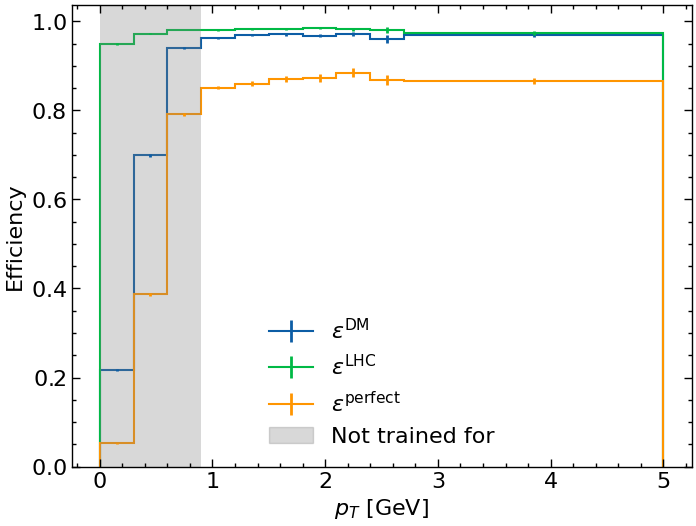

In [13]:
p = PerformancePlot(df=vs_pt, xs=pts, var=vm["pt"].latex + " [GeV]")
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.add_blocked(0, 0.9)
p.add_legend()
p.ax.get_figure().savefig(Path.home() / "paperresults/vs_pt.pdf")

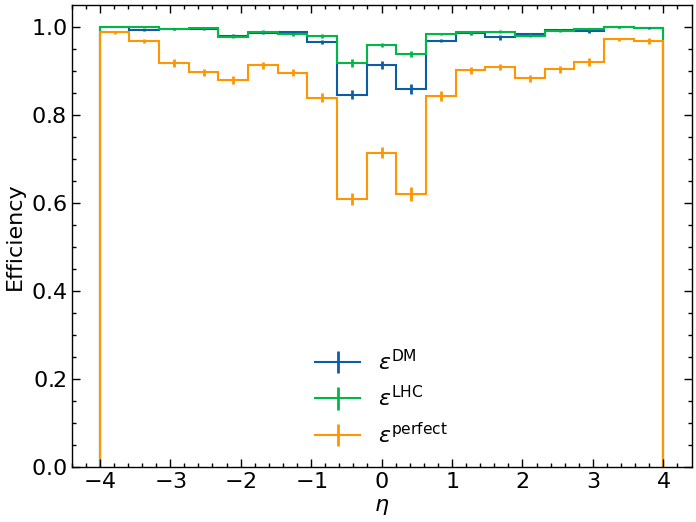

In [14]:
p = PerformancePlot(df=vs_eta, xs=etas, var=vm["eta"].latex)
p.plot_var("double_majority", "C0")
p.plot_var("lhc", "C1")
p.plot_var("perfect", "C2")
p.ax.legend()
p.add_legend()
p.ax.get_figure().savefig(Path.home() / "paperresults/vs_eta.pdf")

/tmp/ipykernel_245785/1904660633.py:46: UserWarning: The label '_ignore' of (<matplotlib.patches.StepPatch object at 0x1485422a6230>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


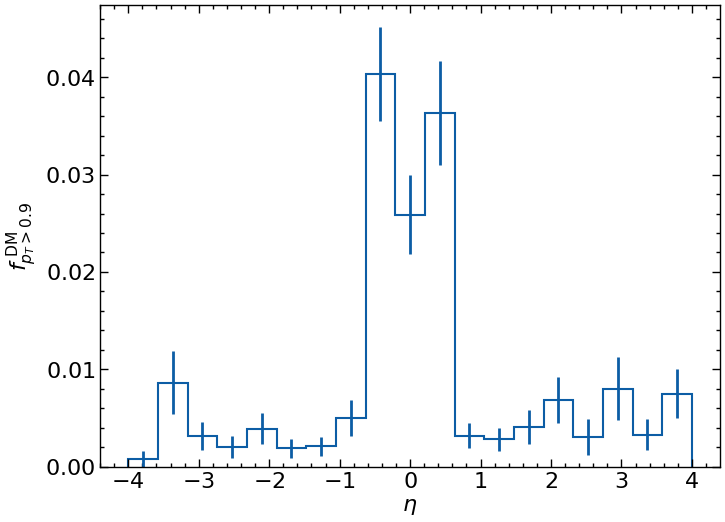

In [15]:
p = PerformancePlot(
    df=vs_eta,
    df_ul=None,
    xs=etas,
    var=vm["eta"].latex,
    y_label=r"$f^{\,\,\mathrm{DM}}_{p_T>0.9}$",
)
p.plot_var("fake_double_majority", "C0", label="_ignore")
p.add_legend()
p.ax.get_figure().savefig(Path.home() / "paperresults/fake_vs_eta.pdf")

/tmp/ipykernel_245785/1904660633.py:46: UserWarning: The label '_' of (<matplotlib.patches.StepPatch object at 0x1485420adff0>, <ErrorbarContainer object of 3 artists>) starts with '_'. It is thus excluded from the legend.
  self.ax.legend(all_handles, all_labels, **kwargs)


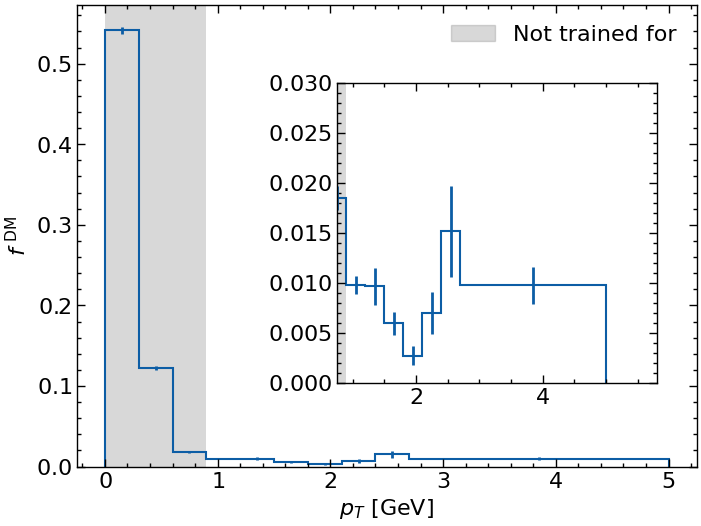

In [17]:
p = PerformancePlot(
    df=vs_pt,
    df_ul=None,
    xs=pts,
    var=vm["pt"].latex + " [GeV]",
    y_label=r"$f^{\,\,\mathrm{DM}}$",
)
p.add_blocked(0, 0.9)
# p.ax.set_ylim(0., 0.05)
p.plot_var("fake_double_majority", "C0", label="_")
p.add_legend()

left, bottom, width, height = [0.45, 0.25, 0.4, 0.5]
ax2 = p.ax.get_figure().add_axes([left, bottom, width, height])
p = PerformancePlot(df=vs_pt, df_ul=None, xs=pts, var="", y_label="", ax=ax2)
p.add_blocked(0, 0.9)
p.ax.set_xlim(0.75, 5.8)
p.ax.set_ylim(0.0, 0.03)
p.plot_var("fake_double_majority", "C0", label="_")

p.ax.get_figure().savefig(Path.home() / "paperresults/fake_vs_eta.pdf")